# Classification methods overview
### February 28, 2019
### Luis Da Silva

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Supervised Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC # https://scikit-learn.org/stable/modules/svm.html#svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda
from sklearn.ensemble import RandomForestClassifier # https://scikit-learn.org/stable/modules/ensemble.html#random-forests
from sklearn.ensemble import GradientBoostingClassifier # https://scikit-learn.org/stable/modules/ensemble.html#classification

# Unsupervised Algorithms https://scikit-learn.org/stable/modules/clustering.html
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [2]:
# Custom feature selection package, check it out at: https://github.com/luisds95/scikit-learn-helpers
import sys
sys.path.insert(0, 'D:\\OneDrive\\Git\\scikit-learn-helpers')
import sklearnHelpers as skh

# Functions

In [3]:
def cv(model, X, y):
    return np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))

In [4]:
def scaler(x):
    x = np.array(x)
    return (x - x.mean())/x.std()

In [5]:
def sup_scores(model, X, y):
    scores = {'supervised':True}
    scores['f1'] = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    scores['accuracy'] = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    scores['recall'] = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    scores['precision'] = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    return scores

In [6]:
def unsup_scores(y, y_pred):
    scores = {'supervised':False}
    scores['f1'] = f1_score(y, y_pred)
    scores['accuracy'] = accuracy_score(y, y_pred)
    scores['recall'] = recall_score(y, y_pred)
    scores['precision'] = precision_score(y, y_pred)
    return scores

In [56]:
def plot_contour(model, params, subx, x1n, x2n, x1a, x2a, supervised=True, reverse=False, suffix=''):
    xg, yg = np.meshgrid(np.arange(-4.1, 4.1, 0.1),np.arange(-4.1, 4.1, 0.1))
    
    l = model(**params)
    if supervised == True:
        l.fit(subx, y)
    else:
        l.fit(subx)
    zz = l.predict(np.c_[xg.ravel(), yg.ravel()])
    zz = zz.reshape(xg.shape)
    
    c1='blue'
    c2='red'
    if reverse:
        c1='red'
        c2='blue'
    
    plt.figure(figsize=(4,4))
    plt.contourf(xg, yg, zz, cmap=plt.cm.RdBu, alpha=.3)
    plt.scatter(x1n, x2n, c=c1, alpha=0.6, label='Normal')
    plt.scatter(x1a, x2a, c=c2, alpha=0.6, label='Abnormal')
    plt.xlabel('Spondylolisthesis')
    plt.ylabel('Pelvic Radius')
    plt.xlim((-4, 4))
    plt.ylim((-4, 4))
    #plt.title(type(l).__name__)
    plt.legend()
    plt.savefig('Graphs/{}_contour{}.png'.format(type(l).__name__, suffix))
    plt.show()

# Read in data

In [8]:
df = pd.read_csv('vertebral_column_data.txt', sep=' ', header=None,
                 names=['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope',
                 'pelvic_radius', 'spondylolisthesis', 'normal']) 
df['normal'] = df['normal'] == 'NO'
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,spondylolisthesis,normal
0,63.03,22.55,39.61,40.48,98.67,-0.25,False
1,39.06,10.06,25.02,29.00,114.41,4.56,False
2,68.83,22.22,50.09,46.61,105.99,-3.53,False
3,69.30,24.65,44.31,44.64,101.87,11.21,False
4,49.71,9.65,28.32,40.06,108.17,7.92,False


In [9]:
df.shape

(310, 7)

In [10]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


In [11]:
df.groupby('normal').count()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,spondylolisthesis
normal,,,,,,
False,210,210,210,210,210,210
True,100,100,100,100,100,100


In [12]:
# As data is slightly unbalanced, let's balance it:
np.random.seed = 542
normals = df[df['normal']]
unnormals = df[~df['normal']]
unnormals = unnormals.iloc[np.random.choice(len(unnormals), len(normals), replace=False)]
ndf = normals.append(unnormals)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


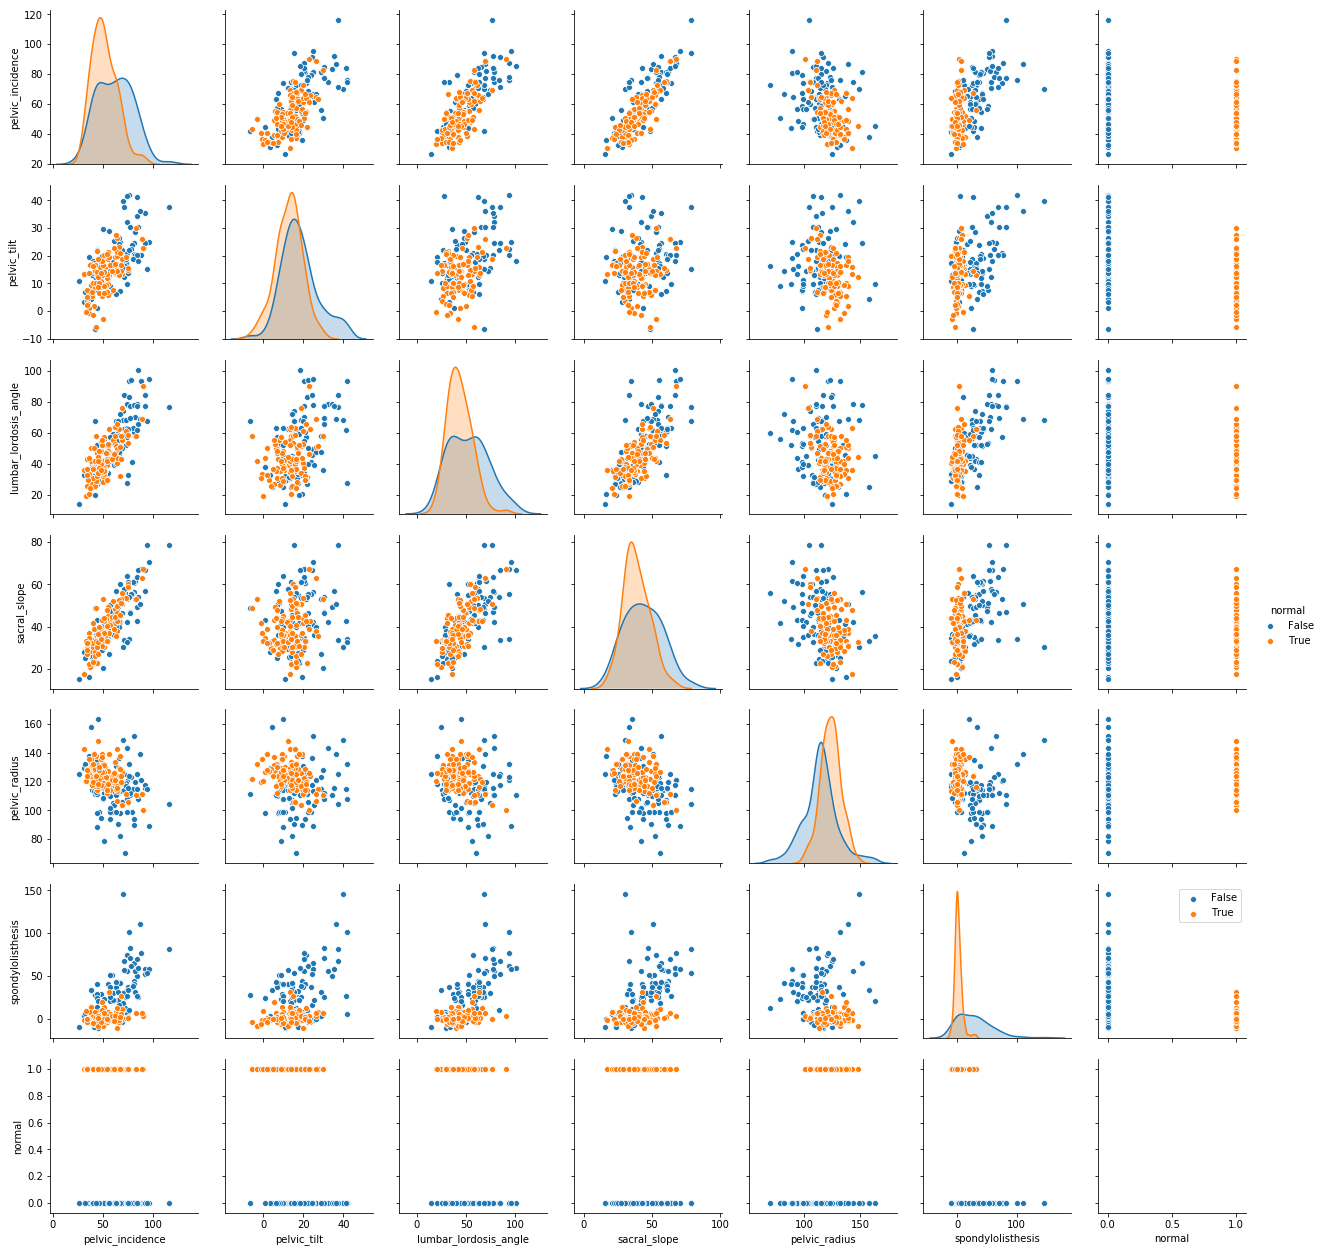

In [13]:
sns.pairplot(ndf, hue='normal')
plt.legend()
plt.savefig('Graphs/pairplot.png')
plt.show()

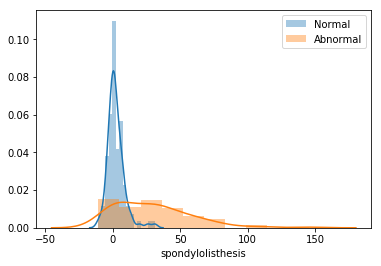

In [14]:
sns.distplot(ndf['spondylolisthesis'][ndf['normal']], label='Normal')
sns.distplot(ndf['spondylolisthesis'][~ndf['normal']], label='Abnormal')
plt.legend()
plt.savefig('Graphs/spondylolisthesis_dist.png')
plt.show()

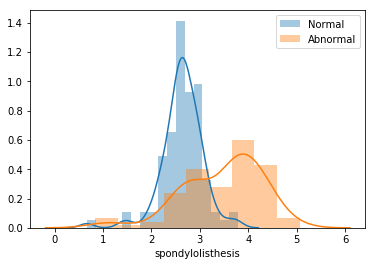

In [15]:
# As spondylolisthesis seems exponential, let's loggit
ndf['spondylolisthesis'] = np.log(ndf['spondylolisthesis']+13)
sns.distplot(ndf['spondylolisthesis'][ndf['normal']], label='Normal')
sns.distplot(ndf['spondylolisthesis'][~ndf['normal']], label='Abnormal')
plt.legend()
plt.savefig('Graphs/log_spondylolisthesis_dist.png')
plt.show()

In [16]:
# Also, as some methods rely on distance, let's scale the variables
X = ndf.drop('normal', axis=1)
for x in X:
    X[x] = scaler(X[x])
y = ndf['normal']

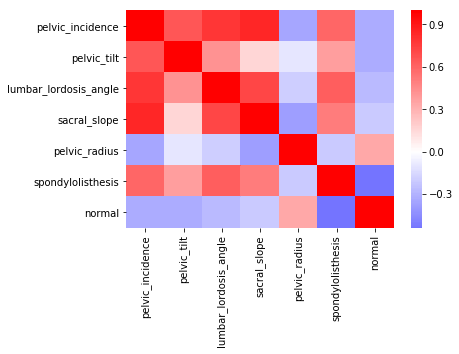

In [17]:
sns.heatmap(ndf.corr(), cmap='bwr', center=0)
plt.show()

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


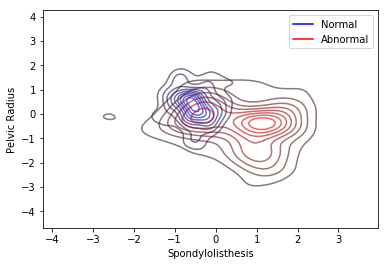

In [47]:
subx = X[['spondylolisthesis', 'pelvic_radius']]
x1n = X[y]['spondylolisthesis']
x2n = X[y]['pelvic_radius']
x1a = X[~y]['spondylolisthesis']
x2a = X[~y]['pelvic_radius']
plt.figure(figsize=(6,4))
sns.kdeplot(x1n, x2n, color='blue', alpha=0.6, label='Normal')
sns.kdeplot(x1a, x2a, color='red', alpha=0.6, label='Abnormal')
plt.xlabel('Spondylolisthesis')
plt.ylabel('Pelvic Radius')
plt.legend()
plt.savefig('Graphs/two_features_KDE.png')
plt.show()

# Using PCA to try to visualize
It doesn't work

In [19]:
pca = PCA()
X_trans = pca.fit_transform(X)
pca.explained_variance_ratio_

array([5.77935594e-01, 1.67799801e-01, 1.27704222e-01, 8.66798742e-02,
       3.98804976e-02, 1.12601433e-08])

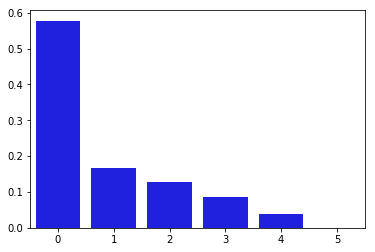

In [20]:
sns.barplot(x=np.arange(6), y=pca.explained_variance_ratio_, color='blue')
plt.show()

# Supervised Algorithms

In [21]:
all_scores = {}

Initializing best subset selection process...
9.52% completed so far. Best score: 0.7700.
Time spent: 0:00:00.145618. Time remaining: 0:00:01.383371.
33.33% completed so far. Best score: 0.7850.
Time spent: 0:00:00.513629. Time remaining: 0:00:01.027258.
65.08% completed so far. Best score: 0.7850.
Time spent: 0:00:01.010302. Time remaining: 0:00:00.542113.
88.89% completed so far. Best score: 0.7850.
Time spent: 0:00:01.428182. Time remaining: 0:00:00.178523.
98.41% completed so far. Best score: 0.7850.
Time spent: 0:00:01.573811. Time remaining: 0:00:00.025384.
100.00% completed so far. Best score: 0.7850.
Time spent: 0:00:01.600723. Time remaining: 0:00:00.
Model LogisticRegression:
Score: 0.785
Subset: ['pelvic_incidence', 'sacral_slope', 'pelvic_radius', 'spondylolisthesis']
Parameters: {'C': 0.7000000000000001, 'solver': 'lbfgs'}
--------------------
{'supervised': True, 'f1': 0.799818491208168, 'accuracy': 0.7899999999999999, 'recall': 0.8400000000000001, 'precision': 0.76455486

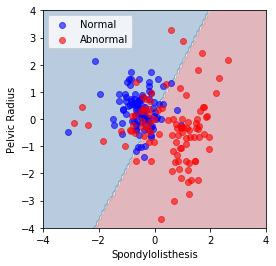

In [57]:
# Logistic Regression
logic = LogisticRegression(solver='lbfgs')
param_grid = {'C': np.linspace(0.1, 1, 10), 'solver':['lbfgs']}
logic = skh.tune_fit_model(X, y, logic, scoring='accuracy', best_subset=True, param_grid=param_grid)
all_scores['LogisticRegression'] = sup_scores(logic['model'], X[logic['subset']], y)
print(all_scores['LogisticRegression'])
plot_contour(LogisticRegression, logic['parameters'], subx, x1n, x2n, x1a, x2a)

Initializing best subset selection process...
9.52% completed so far. Best score: 0.7800.
Time spent: 0:00:00.114690. Time remaining: 0:00:01.089555.
33.33% completed so far. Best score: 0.8000.
Time spent: 0:00:00.381015. Time remaining: 0:00:00.762030.
65.08% completed so far. Best score: 0.8200.
Time spent: 0:00:00.671238. Time remaining: 0:00:00.360176.
88.89% completed so far. Best score: 0.8200.
Time spent: 0:00:00.896609. Time remaining: 0:00:00.112076.
98.41% completed so far. Best score: 0.8200.
Time spent: 0:00:01.006336. Time remaining: 0:00:00.016231.
100.00% completed so far. Best score: 0.8200.
Time spent: 0:00:01.023292. Time remaining: 0:00:00.
Model KNeighborsClassifier:
Score: 0.82
Subset: ['lumbar_lordosis_angle', 'pelvic_radius', 'spondylolisthesis']
Parameters: {'metric': 'minkowski', 'n_neighbors': 5}
--------------------
{'supervised': True, 'f1': 0.8351718812588377, 'accuracy': 0.82, 'recall': 0.9, 'precision': 0.7838396515764938}


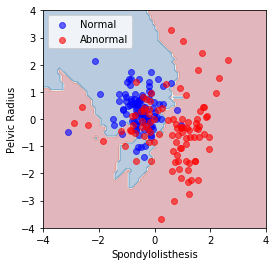

In [76]:
# KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors':np.arange(1, 9, 2), 'metric':['minkowski', 'euclidean', 'manhattan', 'chebyshev']}
knn = skh.tune_fit_model(X, y, knn, scoring='accuracy', best_subset=True, param_grid=param_grid)
all_scores['KNeighborsClassifier'] = sup_scores(knn['model'], X[knn['subset']], y)
print(all_scores['KNeighborsClassifier'])
plot_contour(KNeighborsClassifier, knn['parameters'], subx, x1n, x2n, x1a, x2a)

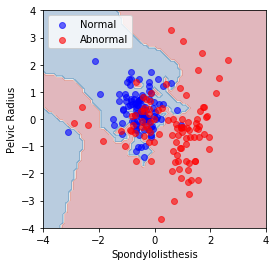

In [59]:
plot_contour(KNeighborsClassifier, {'n_neighbors':1}, subx, x1n, x2n, x1a, x2a, suffix='_overfitted')

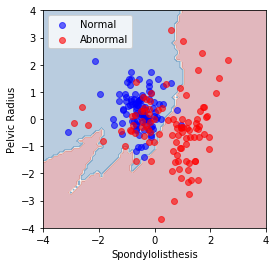

In [77]:
plot_contour(KNeighborsClassifier, {'n_neighbors':19}, subx, x1n, x2n, x1a, x2a, suffix='_underfitted')

Initializing best subset selection process...
9.52% completed so far. Best score: 0.7850.
Time spent: 0:00:00.113669. Time remaining: 0:00:01.079856.
33.33% completed so far. Best score: 0.7900.
Time spent: 0:00:00.387937. Time remaining: 0:00:00.775874.
65.08% completed so far. Best score: 0.8400.
Time spent: 0:00:00.702123. Time remaining: 0:00:00.376749.
88.89% completed so far. Best score: 0.8400.
Time spent: 0:00:01.056156. Time remaining: 0:00:00.132020.
98.41% completed so far. Best score: 0.8400.
Time spent: 0:00:01.149900. Time remaining: 0:00:00.018547.
100.00% completed so far. Best score: 0.8400.
Time spent: 0:00:01.166911. Time remaining: 0:00:00.
Model SVC:
Score: 0.8400000000000001
Subset: ['lumbar_lordosis_angle', 'pelvic_radius', 'spondylolisthesis']
Parameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
--------------------
{'supervised': True, 'f1': 0.8573275916829395, 'accuracy': 0.8400000000000001, 'recall': 0.95, 'precision': 0.7845397356266922}


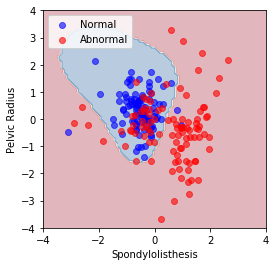

In [90]:
# SVM
svm = SVC(gamma='auto')
param_grid = {'C': np.linspace(0.2, 2, 10), 'gamma':['auto', 'scale'],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
svm = skh.tune_fit_model(X, y, svm, scoring='accuracy', best_subset=True, param_grid=param_grid)
all_scores['SupportVectorMachines'] = sup_scores(svm['model'], X[svm['subset']], y)
print(all_scores['SupportVectorMachines'])
plot_contour(SVC, svm['parameters'], subx, x1n, x2n, x1a, x2a)

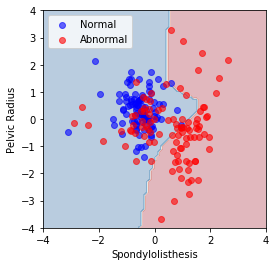

In [86]:
plot_contour(SVC, {'C': 1.0, 'gamma': 'auto', 'kernel': 'poly'}, subx, x1n, x2n, x1a, x2a, suffix='_poly')

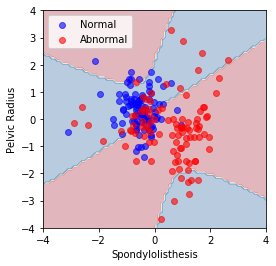

In [89]:
plot_contour(SVC, {'C': 1.0, 'gamma': 'auto', 'kernel': 'sigmoid'}, subx, x1n, x2n, x1a, x2a, suffix='_sigmoid')

Initializing best subset selection process...
9.52% completed so far. Best score: 0.7800.
Time spent: 0:00:00.109681. Time remaining: 0:00:01.041970.
33.33% completed so far. Best score: 0.7850.
Time spent: 0:00:00.396913. Time remaining: 0:00:00.793826.
65.08% completed so far. Best score: 0.8000.
Time spent: 0:00:00.729025. Time remaining: 0:00:00.391184.
88.89% completed so far. Best score: 0.8000.
Time spent: 0:00:01.009274. Time remaining: 0:00:00.126159.
98.41% completed so far. Best score: 0.8000.
Time spent: 0:00:01.112997. Time remaining: 0:00:00.017952.
100.00% completed so far. Best score: 0.8000.
Time spent: 0:00:01.135935. Time remaining: 0:00:00.
Model LinearDiscriminantAnalysis:
Score: 0.8
Subset: ['pelvic_tilt', 'pelvic_radius', 'spondylolisthesis']
Parameters: {'n_components': 2, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
--------------------
{'supervised': True, 'f1': 0.8157817814137328, 'accuracy': 0.8, 'recall': 0.8

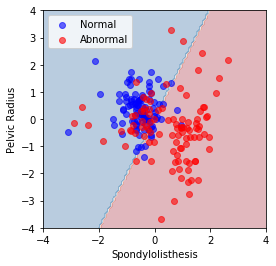

In [62]:
# LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda = skh.tune_fit_model(X, y, lda, scoring='accuracy', best_subset=True)
all_scores['LinearDiscriminantAnalysis'] = sup_scores(lda['model'], X[lda['subset']], y)
print(all_scores['LinearDiscriminantAnalysis'])
plot_contour(LinearDiscriminantAnalysis, lda['parameters'], subx, x1n, x2n, x1a, x2a)

Initializing best subset selection process...
9.52% completed so far. Best score: 0.6850.
Time spent: 0:00:02.686811. Time remaining: 0:00:25.524704.
33.33% completed so far. Best score: 0.7900.
Time spent: 0:00:08.753591. Time remaining: 0:00:17.507182.
65.08% completed so far. Best score: 0.8050.
Time spent: 0:00:16.773153. Time remaining: 0:00:09.000228.
88.89% completed so far. Best score: 0.8250.
Time spent: 0:00:22.990533. Time remaining: 0:00:02.873817.
98.41% completed so far. Best score: 0.8250.
Time spent: 0:00:25.557668. Time remaining: 0:00:00.412220.
100.00% completed so far. Best score: 0.8250.
Time spent: 0:00:25.988514. Time remaining: 0:00:00.
Model RandomForestClassifier:
Score: 0.825
Subset: ['pelvic_tilt', 'sacral_slope', 'pelvic_radius', 'spondylolisthesis']
Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
--------------------
{'supervised': True, 'f1': 0.8161778671428725, 'accuracy': 0.7899999999999999, 'recall': 0.8699999999999999, 'preci

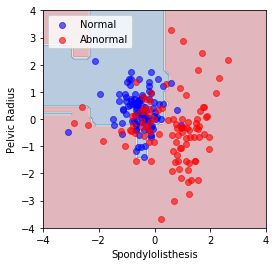

In [63]:
# Random Forests
rf = RandomForestClassifier(n_estimators=100)
param_grid = {'max_depth':np.arange(1, 5), 'max_features':['sqrt'], 'n_estimators':np.arange(100, 350, 50)}
rf = skh.tune_fit_model(X, y, rf, scoring='accuracy', best_subset=True, param_grid=param_grid)
all_scores['RandomForestClassifier'] = sup_scores(rf['model'], X[rf['subset']], y)
print(all_scores['RandomForestClassifier'])
plot_contour(RandomForestClassifier, rf['parameters'], subx, x1n, x2n, x1a, x2a)

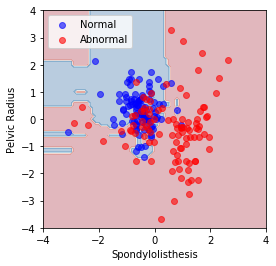

In [64]:
plot_contour(RandomForestClassifier, {'max_depth': None, 'n_estimators': 150}, subx, x1n, x2n, x1a, x2a, suffix='_overfitted')

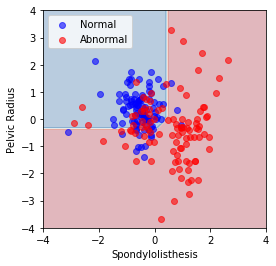

In [65]:
plot_contour(RandomForestClassifier, {'max_depth': 1, 'n_estimators': 150}, subx, x1n, x2n, x1a, x2a, suffix='_underfitted')

Initializing best subset selection process...
9.52% completed so far. Best score: 0.6900.
Time spent: 0:00:01.197823. Time remaining: 0:00:11.379318.
33.33% completed so far. Best score: 0.7700.
Time spent: 0:00:04.270583. Time remaining: 0:00:08.541166.
65.08% completed so far. Best score: 0.8250.
Time spent: 0:00:08.432481. Time remaining: 0:00:04.524746.
88.89% completed so far. Best score: 0.8250.
Time spent: 0:00:11.936090. Time remaining: 0:00:01.492011.
98.41% completed so far. Best score: 0.8250.
Time spent: 0:00:13.507887. Time remaining: 0:00:00.217869.
100.00% completed so far. Best score: 0.8250.
Time spent: 0:00:13.733285. Time remaining: 0:00:00.
Model GradientBoostingClassifier:
Score: 0.825
Subset: ['sacral_slope', 'pelvic_radius', 'spondylolisthesis']
Parameters: {'learning_rate': 0.018000000000000002, 'n_estimators': 350}
--------------------
{'supervised': True, 'f1': 0.8308910469375587, 'accuracy': 0.825, 'recall': 0.86, 'precision': 0.806009985437903}


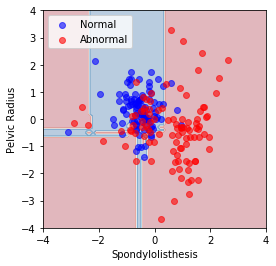

In [66]:
# Gradient Boosting
gb = GradientBoostingClassifier()
param_grid = {'learning_rate':np.arange(0.001, 0.02, 0.001), 'n_estimators':np.arange(300, 450, 50)}
gb = skh.tune_fit_model(X, y, gb, scoring='accuracy', best_subset=True, param_grid=param_grid)
all_scores['GradientBoosting'] = sup_scores(gb['model'], X[gb['subset']], y)
print(all_scores['GradientBoosting'])
plot_contour(GradientBoostingClassifier, gb['parameters'], subx, x1n, x2n, x1a, x2a)

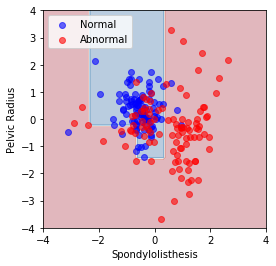

In [67]:
plot_contour(GradientBoostingClassifier, {'learning_rate': 0.01, 'n_estimators': 10}, subx, x1n, x2n, x1a, x2a, suffix='_underfitted')

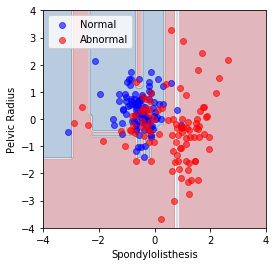

In [68]:
plot_contour(GradientBoostingClassifier, {'learning_rate': 0.5, 'n_estimators': 10}, subx, x1n, x2n, x1a, x2a, suffix='_overfitted')

# Unsupervised Algorithms

{'supervised': False, 'f1': 0.6810810810810811, 'accuracy': 0.705, 'recall': 0.63, 'precision': 0.7411764705882353}


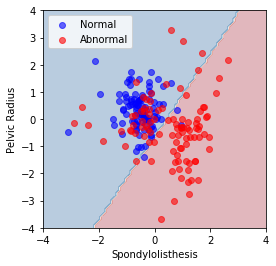

In [117]:
kmeans = KMeans(n_clusters=2).fit(X)
all_scores['KMeans'] = unsup_scores(~y, kmeans.labels_)
print(all_scores['KMeans'])
plot_contour(KMeans, kmeans.get_params(), subx, x1n, x2n, x1a, x2a, False)

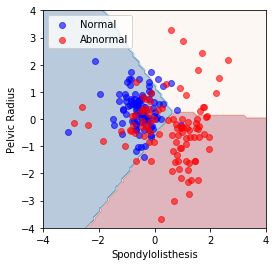

In [105]:
plot_contour(KMeans, {'n_clusters':3}, subx, x1n, x2n, x1a, x2a, False, suffix='_3clusters')

{'supervised': False, 'f1': 0.662251655629139, 'accuracy': 0.745, 'recall': 0.5, 'precision': 0.9803921568627451}


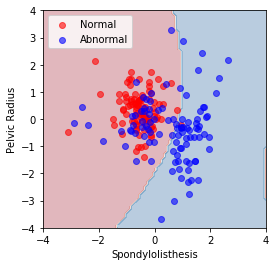

In [107]:
gm = GaussianMixture(n_components=2).fit(X)
all_scores['GaussianMixture'] = unsup_scores(~y, gm.predict(X))
print(all_scores['GaussianMixture'])
plot_contour(GaussianMixture, gm.get_params(), subx, x1n, x2n, x1a, x2a, False, True)

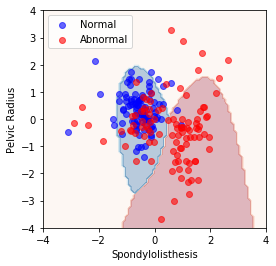

In [115]:
plot_contour(GaussianMixture, {'n_components':3}, subx, x1n, x2n, x1a, x2a, False, suffix='_3clusters')

In [73]:
sc = SpectralClustering(n_clusters=2).fit(X)
all_scores['SpectralClustering'] = unsup_scores(~y, sc.labels_,)
all_scores['SpectralClustering']

{'supervised': False,
 'f1': 0.11320754716981131,
 'accuracy': 0.53,
 'recall': 0.06,
 'precision': 1.0}

In [39]:
agloc = AgglomerativeClustering(n_clusters=2).fit(X)
all_scores['AgglomerativeClustering'] = unsup_scores(y, agloc.labels_)
all_scores['AgglomerativeClustering']

{'supervised': False,
 'f1': 0.7772925764192139,
 'accuracy': 0.745,
 'recall': 0.89,
 'precision': 0.689922480620155}

# Plotting results

In [108]:
scodf = []
for name, score in all_scores.items():
    scodf.append({'model':name, 'Accuracy':score['accuracy'], 'Precision':score['precision'],
                  'Recall':score['recall'], 'F1':score['f1'],}) 
scodf = pd.DataFrame(scodf)
scodf.sort_values(['Accuracy', 'F1'], ascending=False, inplace=True)
scodf.reset_index(inplace=True, drop=True)

In [109]:
melted = pd.melt(scodf, id_vars="model", var_name="Metric", value_name="score")

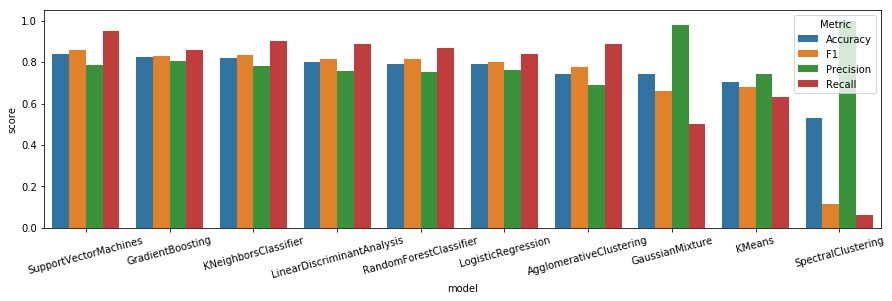

In [116]:
plt.figure(figsize=(15,4))
sns.barplot(x='model', y='score', hue='Metric', data=melted)
plt.xticks(rotation=15)
plt.savefig('Graphs/All_scores.png')
plt.show()

In [111]:
scodf[['model'] + list(scodf.columns[:-1])]

,model,Accuracy,F1,Precision,Recall
0,SupportVectorMachines,0.840,0.857328,0.784540,0.95
1,GradientBoosting,0.825,0.830891,0.806010,0.86
2,KNeighborsClassifier,0.820,0.835172,0.783840,0.90
3,LinearDiscriminantAnalysis,0.800,0.815782,0.755650,0.89
4,RandomForestClassifier,0.790,0.816178,0.750425,0.87
5,LogisticRegression,0.790,0.799818,0.764555,0.84
6,AgglomerativeClustering,0.745,0.777293,0.689922,0.89
7,GaussianMixture,0.745,0.662252,0.980392,0.50
8,KMeans,0.705,0.681081,0.741176,0.63
9,SpectralClustering,0.530,0.113208,1.000000,0.06
